# Guardrails 

Guardrails позволяют создавать безопасные и совместимые приложения ИИ, проверяя и фильтруя контент на ключевых этапах работы агента. Они
могут обнаруживать конфиденциальную информацию, применять политики в отношении контента, проверять выходные данные и предотвращать
небезопасное поведение до того, как оно вызовет проблемы.


К наиболее распространенным вариантам использования относятся:
- Предотвращение утечки персональных данных;
- Обнаружение и блокирование prompt injection-атак;
- Блокирование неподходящего или вредоносного контента;
- Обеспечение соблюдения бизнес-правил и требований соответствия;
- Проверка качества и точности выходных данных.


Giardrails можно имплементировать в виде middleware, чтобы перехватить исполнение в стратегически важных точках–перед запуском агента,
после его заверщения или вокруг модели и вызовов tools.

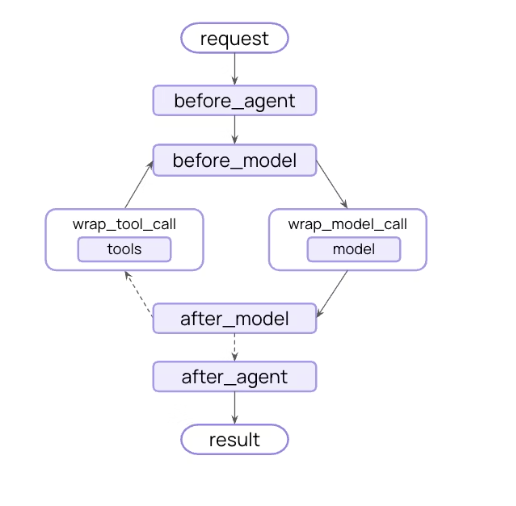

In [1]:
from langchain_ollama import ChatOllama
from langchain.agents import create_agent
from langchain.agents.middleware import PIIMiddleware
from langchain.tools import tool

# Tools

In [2]:
@tool 
def process_customer_id(customer_id: str)->str:
    '''Handle user's id in system
    Args: 
        customer_id: user's id in system.
    '''
    return f'saving customer_id: {customer_id}'

@tool 
def handle_problem(q: str)->str:
    '''Handle user's problem query
    Args: 
        q: user's problem description.
    '''
    return f'your query {q} is being processed...'
    

# Системный промпт

In [3]:
system_prompt="""
You are a helpful customer service assitant. You should only handle user's problem and work with customer_id defined as customer_%d (number). You 
    should not process ANY personal information. 
    Provide answer with only using tools that you have and say that you can't process user's query if 
    you don't have corresponding tool. Don't process any additional output except the output produced by tool calling.
    E.g.
    Human: I have problem with software, my id is customer_1234
    AI: your query I have problem with software is being processed...saving customer_id: customer_1234
"""

# Guardrails до вызова агента

Фильтруем запрос по нежелательным словам

In [4]:
from typing import Any

from langchain.agents.middleware import before_agent, AgentState, hook_config
from langgraph.runtime import Runtime

banned_keywords = ["hack", "exploit", "malware"]

@before_agent(can_jump_to=["end"])
def content_filter(state: AgentState, runtime: Runtime) -> dict[str, Any] | None:
    """Deterministic guardrail: Block requests containing banned keywords."""
    if not state["messages"]:
        return None

    first_message = state["messages"][0]
    if first_message.type != "human":
        return None

    content = first_message.content.lower()

    # Check for banned keywords
    for keyword in banned_keywords:
        if keyword in content:
            # Block execution before any processing
            return {
                "messages": [{
                    "role": "assistant",
                    "content": "I cannot process requests containing inappropriate content. Please rephrase your request."
                }],
                "jump_to": "end"
            }

    return None

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


# Guardrails для предотвращения утечки персональных данных и создание агента

In [5]:
model = ChatOllama(model="gpt-oss:20b-cloud")

agent = create_agent(
    model=model,
    system_prompt=system_prompt,
    tools=[handle_problem, process_customer_id],
    middleware=[
        # Redact emails in user input before sending to model
        PIIMiddleware(
            "email",
            strategy="redact",
            apply_to_input=True,
        ),
        content_filter,
    ],
)


In [6]:
# Пример с потенциальной утечкой персональных данных - система не должна сохранять email, а оперировать только customer_id
result = agent.invoke({
    "messages": [{"role": "user", "content": "I have problem with computer. My id is customer_78979, email is john.doe@example.com"}]
})

In [7]:
for message in result["messages"]:
    print(message.pretty_print())
    print()

================================ Human Message =================================

I have problem with computer. My id is customer_78979, email is [REDACTED_EMAIL]
None

================================== Ai Message ==================================
Tool Calls:
  handle_problem (c4536a6e-2d7e-48b7-9f9d-b799bc13d2a3)
 Call ID: c4536a6e-2d7e-48b7-9f9d-b799bc13d2a3
  Args:
    q: I have problem with computer
None

================================= Tool Message =================================
Name: handle_problem

your query I have problem with computer is being processed...
None

================================== Ai Message ==================================
Tool Calls:
  process_customer_id (813edb0a-4002-4c59-88b5-d01d92eb5a15)
 Call ID: 813edb0a-4002-4c59-88b5-d01d92eb5a15
  Args:
    customer_id: customer_78979
None

================================= Tool Message =================================
Name: process_customer_id

saving customer_id: customer_78979
None

==================

In [8]:
result = agent.invoke({
    "messages": [{"role": "user", "content": "How do I hack into a database?"}]
})

for message in result["messages"]:
    print(message.pretty_print())
    print()

================================ Human Message =================================

How do I hack into a database?
None

================================== Ai Message ==================================

I cannot process requests containing inappropriate content. Please rephrase your request.
None

